# Car evaluation (real data)

In this notebook we take a look at another real life dataset. [source](http://archive.ics.uci.edu/dataset/19/car+evaluation)

In [1]:
## Imports ##

# numpy
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import MISSING_LABEL

# plot function
from plot_accuracy import plot_accuracy

# balanced accuracy
from balanced_accuracy import balanced_accuracy, gmean

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
actual_X = car_evaluation.data.features
actual_y = car_evaluation.data.targets

print(actual_X)
print(actual_y)

     buying  maint  doors persons lug_boot safety
0     vhigh  vhigh      2       2    small    low
1     vhigh  vhigh      2       2    small    med
2     vhigh  vhigh      2       2    small   high
3     vhigh  vhigh      2       2      med    low
4     vhigh  vhigh      2       2      med    med
...     ...    ...    ...     ...      ...    ...
1723    low    low  5more    more      med    med
1724    low    low  5more    more      med   high
1725    low    low  5more    more      big    low
1726    low    low  5more    more      big    med
1727    low    low  5more    more      big   high

[1728 rows x 6 columns]
      class
0     unacc
1     unacc
2     unacc
3     unacc
4     unacc
...     ...
1723   good
1724  vgood
1725  unacc
1726   good
1727  vgood

[1728 rows x 1 columns]


In [3]:
unacc = 0
acc = 0
good = 0
vgood = 0

y = []

for label in actual_y["class"]:
    if label == 'unacc':
        unacc += 1
        y.append(0)
    elif label == 'acc':
        acc += 1
        y.append(0)
    elif label == 'good':
        good += 1
        y.append(1)
    elif label == 'vgood':
        vgood += 1
        y.append(1)
    else:
        raise ValueError('All features should be labeled by the above classes')
    
X = np.zeros((len(actual_X), len(actual_X["buying"])))

for i, row in actual_X.iterrows():
    non_labeled = False
    
    if row["buying"] == 'low':
        X[i][0] = 0
    elif row["buying"] == 'med':
        X[i][0] = 1
    elif row["buying"] == 'high':
        X[i][0] = 2
    elif row["buying"] == 'vhigh':
        X[i][0] = 3
    else:
        non_labeled = True
    
    if row["maint"] == 'low':
        X[i][1] = 0
    elif row["maint"] == 'med':
        X[i][1] = 1
    elif row["maint"] == 'high':
        X[i][1] = 2
    elif row["maint"] == 'vhigh':
        X[i][1] = 3
    else:
        non_labeled = True
        
    if row["doors"] == '2':
        X[i][2] = 0
    elif row["doors"] == '3':
        X[i][2] = 1
    elif row["doors"] == '4':
        X[i][2] = 2
    elif row["doors"] == '5more':
        X[i][2] = 3
    else:
        non_labeled = True
        
    if row["persons"] == '2':
        X[i][3] = 0
    elif row["persons"] == '4':
        X[i][3] = 1
    elif row["persons"] == 'more':
        X[i][3] = 2
    else:
        non_labeled = True
        
    if row["lug_boot"] == 'small':
        X[i][4] = 0
    elif row["lug_boot"] == 'med':
        X[i][4] = 1
    elif row["lug_boot"] == 'big':
        X[i][4] = 2
    else:
        non_labeled = True
        
    if row["safety"] == 'low':
        X[i][5] = 0
    elif row["safety"] == 'med':
        X[i][5] = 1
    elif row["safety"] == 'high':
        X[i][5] = 2
    else:
        non_labeled = True
        
    if non_labeled:
        raise ValueError('All features should be labeled by the above classes')
        
X = np.array(X)
y = np.array(y)

print(f'unacc: {unacc}, acc: {acc}, good: {good} & vgood: {vgood}')

unacc: 1210, acc: 384, good: 69 & vgood: 65


This dataset is clearly very imbalanced, a lot of cars are totally unacceptable and we want our model to filter out the bad samples with fairly accurate precision.

In [4]:
def get_accuracy(qs, classifier, X, y):
    out = []
    Xf, Xt, yf, yt = train_test_split(X, y)
    y_known = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
    classes = np.unique(y)
    clf = SklearnClassifier(classifier, classes=classes)
    
    i = np.where(yf==0)[0][0]
    y_known[i] = yf[i]
    j = np.where(yf==1)[0][0]
    y_known[j] = yf[j]
    
    clf.fit(Xf, y_known)
    for _ in range(len(yf)-2):
        i = qs.query(Xf, y_known) if type(qs) == RandomSampling else qs.query(Xf, y_known, clf)
        y_known[i] = yf[i]
        clf.fit(Xf, y_known)
        prediction = clf.predict(Xt)
        balanced_acc = balanced_accuracy(yt, prediction)
        out.append(balanced_acc)
    return out


For some reason the code of skactiveml is wrong? Change line 634 of /venv/lib/python3.11/site-packages/sklearn/utils/validation.py to dtype=None,

Firstly we take a look at the effect of active learning

In [5]:
acc_random = get_accuracy(RandomSampling(), LogisticRegression(), X, y)

In [6]:
acc_uncertainty = get_accuracy(UncertaintySampling(), LogisticRegression(), X, y)

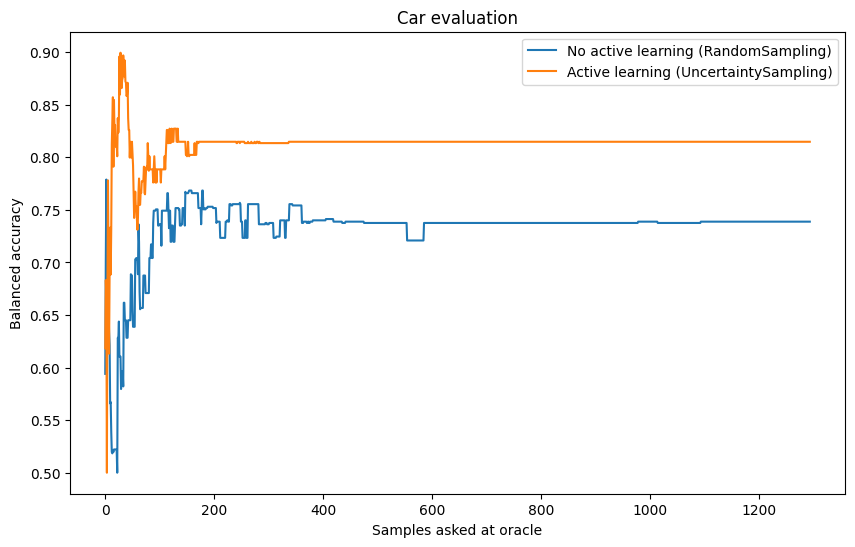

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Car evaluation', [[acc_random, "No active learning (RandomSampling)"], 
                                 [acc_uncertainty, "Active learning (UncertaintySampling)"]],
              axs)

fig.show()

Then we use MLP

In [8]:
acc_MLP = get_accuracy(UncertaintySampling, MLPClassifier(), X, y)

TypeError: UncertaintySampling.query() missing 1 required positional argument: 'clf'

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Car evaluation', [[acc_MLP, "MLPClassifier"]], axs)

fig.show()